# 필요한 라이브러리 import

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
import warnings
from sklearn.metrics import mean_absolute_error
import pickle
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import QuantileTransformer,StandardScaler,PowerTransformer,MinMaxScaler
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor as vif
from itertools import combinations
from tensorflow.keras.models import Model,load_model
from tensorflow.keras.layers import Dense,Input,Dropout
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import KFold
from scipy.stats import spearmanr
import tensorflow as tf
warnings.filterwarnings(action='ignore')
plt.rc('font',family='Malgun Gothic')
plt.rc('font',size=10)
%matplotlib inline

# 데이터로드

In [2]:
# 빈 데이터 프레임 생성

fm_data_df = pd.DataFrame(columns=['이름','포지션','골','도움','경기당 팀 득점/90',
                                 '경기당 팀 실점/90', 'Cr C/A', 'FA', '반칙 수/90', '기회 창출/90',
                                 '경기당 유효 슈팅/90', '경기당 슈팅/90', 'Int/90', '달린 거리/90분', 
                                 '공중 A/90', '태클 성공률','경기당 패스 시도/90', '경기당 패스 성공/90', 
                                 'K Ps/90', '태클 성공/90', '드리블 성공/90', 
                                 '헤더 성공/90', 'Cr A/90', '평균획득승점/경기'])

# 모든 데이터 프레임 이어붙이기
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2021-2022/2021-2022ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2022-2023/2022-2023ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)
fm_data_df = pd.concat([fm_data_df,pd.read_csv('./datas/NEW_FM_DATA_FOR_ML/2023-2024/2023-2024ML.csv',encoding='utf-8-sig')])
fm_data_df = fm_data_df.reset_index(drop=True)

# 데이터 프레임 컬럼명 변경 및 자료형 변경
fm_data_df.rename(columns={'Cr C/A':'크로스 성공률','FA':'파울 획득','Int/90':'인터셉트/90','공중 A/90':'공중볼시도/90','K Ps/90':'키패스/90','Cr A/90':'크로스 시도/90'},inplace=True)
fm_data_df = fm_data_df.astype({'골':np.int64,'도움':np.int64,'파울 획득':np.int64,'태클 성공률':np.int64})

# 공격수만 추출
forward_df = fm_data_df[fm_data_df['포지션']=='공격수']
forward_df = forward_df.reset_index(drop=True)

# 데이터 EDA

## 모델 생성에 사용할 독립변수, 종속변수 선별

In [3]:
num_col = [forward_df.columns[i] for i,x in enumerate(forward_df.dtypes) if x == 'int64' or x == 'float64']
independent_value = set(num_col) - set(['평균획득승점/경기','출장시간','승','무','패','경기당 팀 득점/90','경기당 팀 실점/90'])
dependent_value = '평균획득승점/경기'

## 결측치 확인

In [4]:
forward_df.isna().sum()

이름              0
포지션             0
골               0
도움              0
경기당 팀 득점/90     0
경기당 팀 실점/90     0
크로스 성공률         0
파울 획득           0
반칙 수/90         0
기회 창출/90        0
경기당 유효 슈팅/90    0
경기당 슈팅/90       0
인터셉트/90         0
달린 거리/90분       0
공중볼시도/90        0
태클 성공률          0
경기당 패스 시도/90    0
경기당 패스 성공/90    0
키패스/90          0
태클 성공/90        0
드리블 성공/90       0
헤더 성공/90        0
크로스 시도/90       0
평균획득승점/경기       0
시즌              0
dtype: int64

## 변수 별 분포 확인

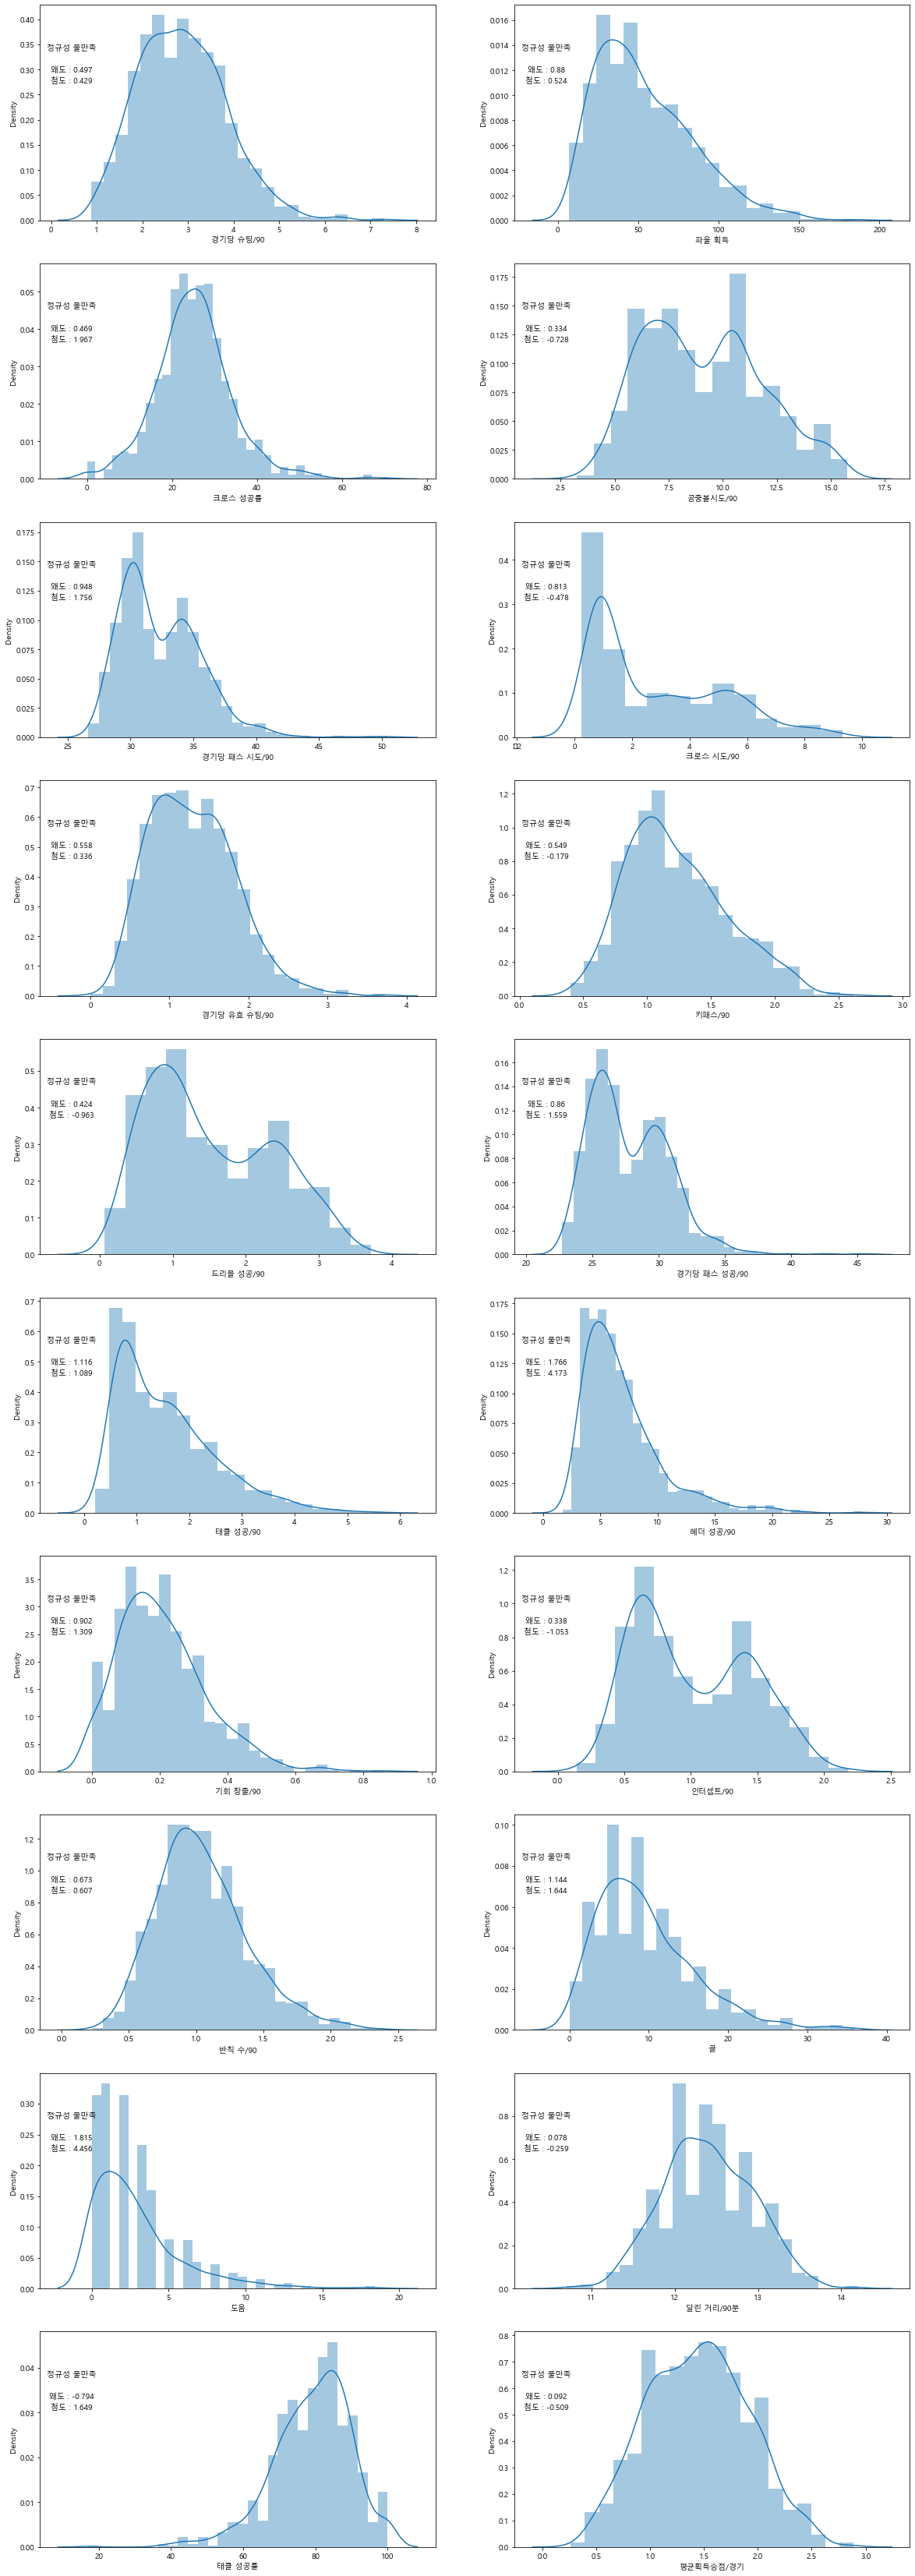

In [5]:
figs , axes = plt.subplots(10,2,figsize=(20,60))

for i,(ax,feature) in enumerate(zip(axes.ravel()[:-1],independent_value)):
    data = forward_df.loc[:,feature]
    sns.distplot(data,ax=ax)
    if stats.shapiro(data)[1]>= 0.05: 
        ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    else:
        ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    skew = stats.skew(data)
    kurtosis = stats.kurtosis(data)
    ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=ax.transAxes)
    

last_ax = axes.ravel()[-1]
depen_data = forward_df.loc[:,dependent_value]
sns.distplot(depen_data,ax=last_ax)

if stats.shapiro(depen_data)[1]>= 0.05: 
    last_ax.text(x=0.08,y=0.8,s='정규성 만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
else:
    last_ax.text(x=0.08,y=0.8,s='정규성 불만족',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
    
skew = stats.skew(depen_data)
kurtosis = stats.kurtosis(depen_data)
last_ax.text(x=0.08,y=0.7,s=f'왜도 : {np.round(skew,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)
last_ax.text(x=0.08,y=0.65,s=f'첨도 : {np.round(kurtosis,3)}',horizontalalignment='center', verticalalignment='center', transform=last_ax.transAxes)

plt.show()
plt.close()

모든 변수가 정규성 불만족 -> 정규화 필요

## 이상치 탐지

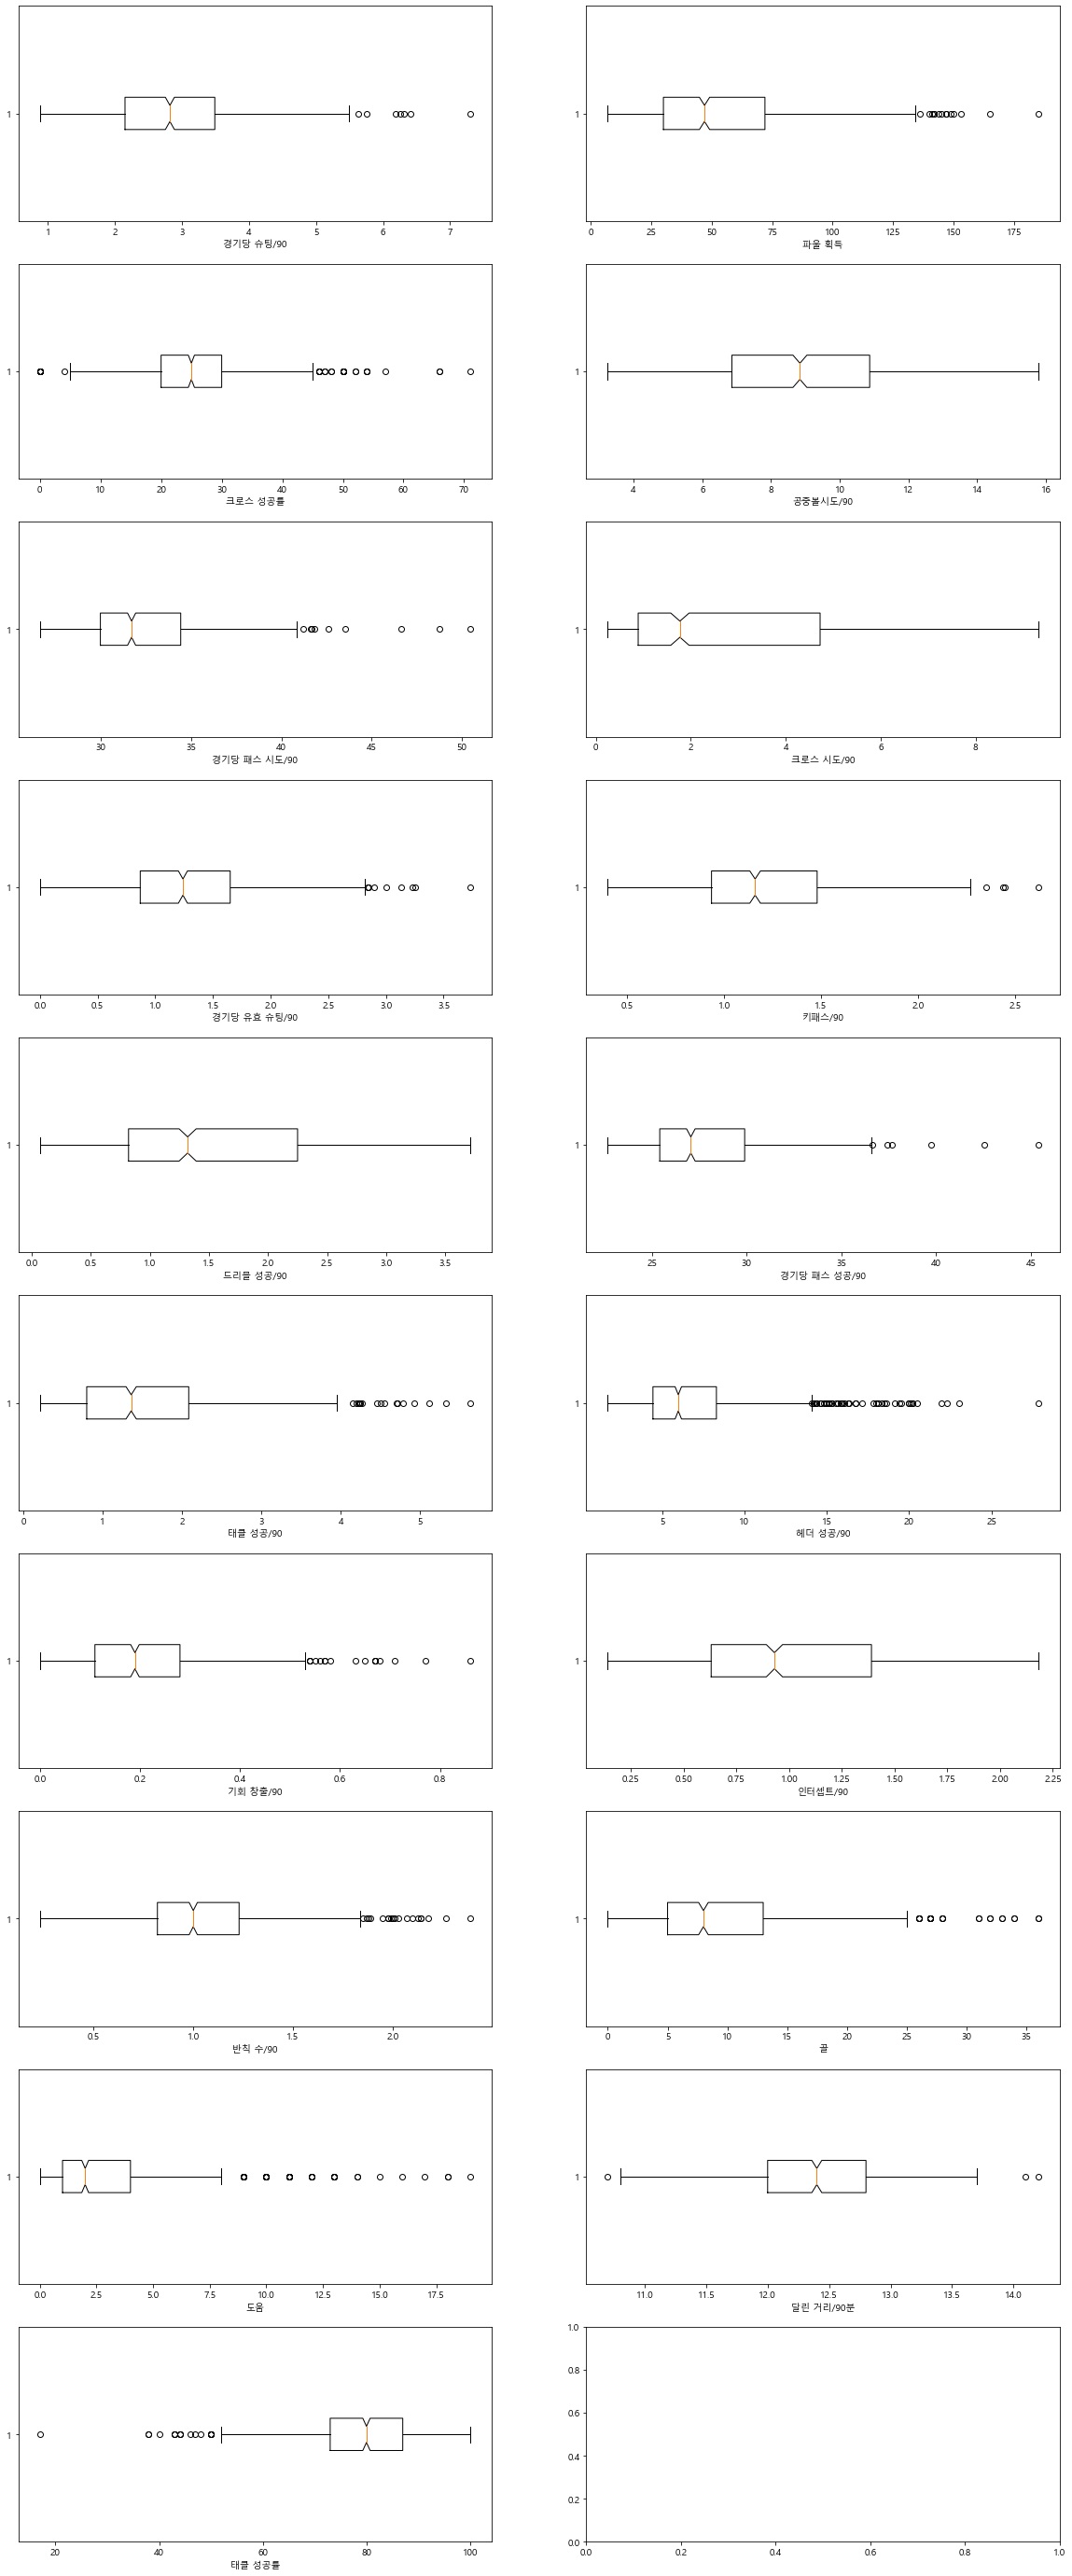

In [6]:
# 모든 변수의 Box plot 시각화

fig , axes = plt.subplots(10,2,figsize=(20,50))

for i, (ax,feature) in enumerate(zip(axes.ravel(),independent_value)) :
    ax.set_xlabel(feature)
    ax.boxplot(forward_df.loc[:,feature],notch=1,vert=0)
    
plt.show()

In [7]:
# 제거해야될 인덱스 셋
total = set([])

for feature in independent_value:
    
    data = forward_df[feature].to_numpy()   
    Q1 = np.quantile(data,0.25)
    Q3 = np.quantile(data,0.7)
    low_bound = Q1 - 1.5 * (Q3-Q1)
    high_bound = Q3 + 1.5 * (Q3-Q1)
    count = 0
    
    for i,v in enumerate(data):
        if v < low_bound or v > high_bound:
            count += 1
            total.add(i)
            
    print(f'{feature}중 이상치는 {count}개 비율은 약 {np.round(count/990*100,3)}% 입니다',end='\n\n')
    
print(f'이상치가 있는 row의 갯수는 총 990개의 데이터 중 {len(total)} 개 입니다.')

경기당 슈팅/90중 이상치는 11개 비율은 약 1.111% 입니다

파울 획득중 이상치는 25개 비율은 약 2.525% 입니다

크로스 성공률중 이상치는 46개 비율은 약 4.646% 입니다

공중볼시도/90중 이상치는 0개 비율은 약 0.0% 입니다

경기당 패스 시도/90중 이상치는 19개 비율은 약 1.919% 입니다

크로스 시도/90중 이상치는 8개 비율은 약 0.808% 입니다

경기당 유효 슈팅/90중 이상치는 15개 비율은 약 1.515% 입니다

키패스/90중 이상치는 26개 비율은 약 2.626% 입니다

드리블 성공/90중 이상치는 0개 비율은 약 0.0% 입니다

경기당 패스 성공/90중 이상치는 8개 비율은 약 0.808% 입니다

태클 성공/90중 이상치는 42개 비율은 약 4.242% 입니다

헤더 성공/90중 이상치는 77개 비율은 약 7.778% 입니다

기회 창출/90중 이상치는 30개 비율은 약 3.03% 입니다

인터셉트/90중 이상치는 0개 비율은 약 0.0% 입니다

반칙 수/90중 이상치는 38개 비율은 약 3.838% 입니다

골중 이상치는 34개 비율은 약 3.434% 입니다

도움중 이상치는 100개 비율은 약 10.101% 입니다

달린 거리/90분중 이상치는 5개 비율은 약 0.505% 입니다

태클 성공률중 이상치는 23개 비율은 약 2.323% 입니다

이상치가 있는 row의 갯수는 총 990개의 데이터 중 363 개 입니다.


이상치를 제거한다면 데이터 손실이 너무 크다.

##  변수간 상관계수 분석 및 다중공선성 확인

### 상관계수

#### 상관계수 시각화

<AxesSubplot:>

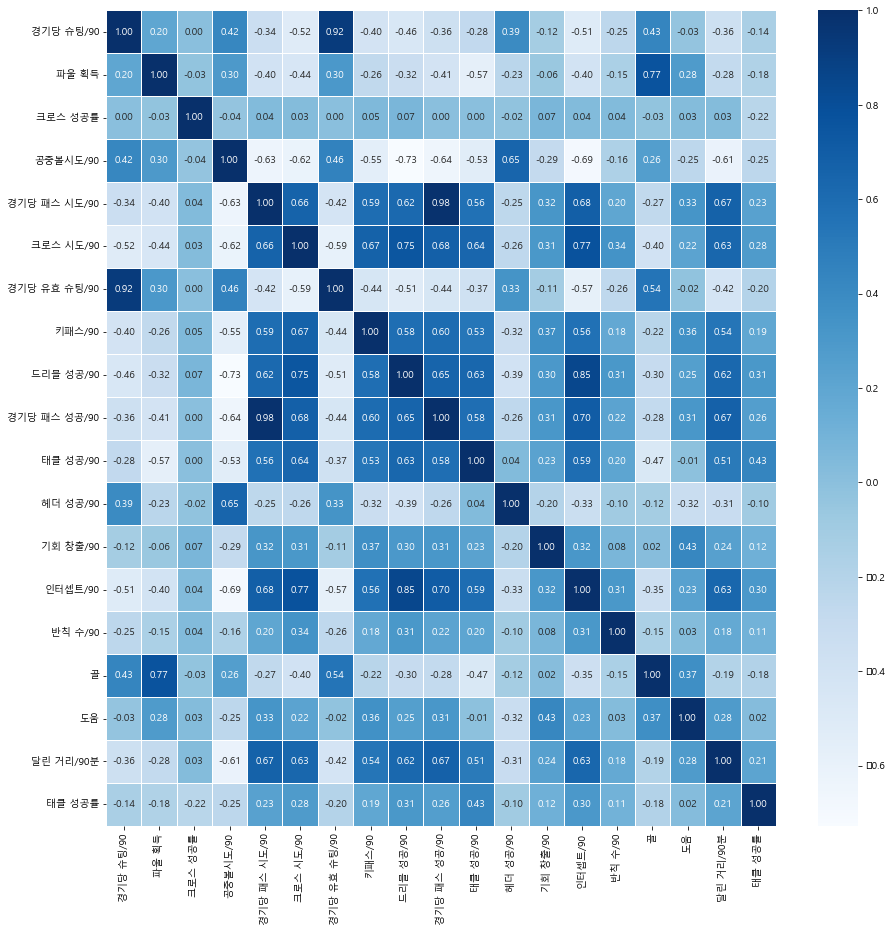

In [8]:
plt.figure(figsize=(15,15))
sns.heatmap(data = forward_df.loc[:,independent_value].corr(), annot=True, 
fmt = '.2f', linewidths=.5, cmap='Blues')

#### 종속변수 간 상관계수 , 독립변수와 상관계수

In [9]:
# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 슈팅/90,경기당 유효 슈팅/90,0.919081
1,파울 획득,골,0.755574
2,공중볼시도/90,드리블 성공/90,-0.753751
3,경기당 패스 시도/90,크로스 시도/90,0.755203
4,경기당 패스 시도/90,경기당 패스 성공/90,0.975738
5,경기당 패스 시도/90,인터셉트/90,0.728283
6,크로스 시도/90,키패스/90,0.701695
7,크로스 시도/90,드리블 성공/90,0.767371
8,크로스 시도/90,경기당 패스 성공/90,0.763061
9,크로스 시도/90,태클 성공/90,0.764686


In [10]:
corr_dict_dependent = {}
corr_list_dependent = []

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for val in independent_value:
    spearmann = spearmanr(forward_df[[val,dependent_value]])
    corr_dict_dependent[f'{val} / {dependent_value}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    corr_list_dependent.append([val,dependent_value,spearmann[0]])

pd.DataFrame(corr_list_dependent,columns=['종속변수','독립변수','상관계수'])

,종속변수,독립변수,상관계수
0,경기당 슈팅/90,평균획득승점/경기,0.281119
1,파울 획득,평균획득승점/경기,0.040846
2,크로스 성공률,평균획득승점/경기,0.012961
3,공중볼시도/90,평균획득승점/경기,-0.240744
4,경기당 패스 시도/90,평균획득승점/경기,0.195827
5,크로스 시도/90,평균획득승점/경기,0.117011
6,경기당 유효 슈팅/90,평균획득승점/경기,0.301633
7,키패스/90,평균획득승점/경기,0.181194
8,드리블 성공/90,평균획득승점/경기,0.228585
9,경기당 패스 성공/90,평균획득승점/경기,0.191469


### 다중공선성

In [11]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,3.724547,도움
1,4.799466,기회 창출/90
2,9.625052,크로스 시도/90
3,9.817092,크로스 성공률
4,12.474020,반칙 수/90
5,13.158411,골
6,13.796837,태클 성공/90
7,15.672334,파울 획득
8,18.684251,헤더 성공/90
9,21.396413,드리블 성공/90


# 데이터 전처리

## 결측치 처리

결측치가 없음

## 다중공선성, 상관계수 처리 (기준: VIF >= 10 , 상관계수 > =+- 0.7) 및 처리

### 여러 변수와 상관계수가 높은 드리블 성공/90, 크로스 시도/90,인터셉트/90 삭제

In [12]:
independent_value = independent_value - {'드리블 성공/90','크로스 시도/90','인터셉트/90'}

# 상관계수의 절대값이 0.7 이상인것들
high_corr_list = []
feature_comb = list(combinations(independent_value,2))
corr_dict_pair = {}

# 골,도움 같은 변수는 범주형 자료이므로 스피어만 상관계수 사용
for a,b in feature_comb:
    spearmann = spearmanr(forward_df[[a,b]])
    corr_dict_pair[f'{a} / {b}'] = (spearmann[0],spearmann[1],spearmann[1]>=0.05)
    
    if spearmann[0] >= 0.7 or spearmann[0] <= -0.7:
        high_corr_list.append([a,b,spearmann[0]])

pd.DataFrame(high_corr_list,columns=['변수 1','변수 2','상관계수'])

,변수 1,변수 2,상관계수
0,경기당 슈팅/90,경기당 유효 슈팅/90,0.919081
1,파울 획득,골,0.755574
2,경기당 패스 성공/90,경기당 패스 시도/90,0.975738


#### 골과 경기당 슈팅, 유효슈팅 묶기

In [14]:
# 0골인 선수 보정

forward_df['골'] = forward_df['골']+1

forward_df['슛정밀도 가중 골'] = (forward_df['경기당 유효 슈팅/90'] / forward_df['경기당 슈팅/90'])*forward_df['골']

independent_value.add('슛정밀도 가중 골')
independent_value = independent_value - set(['골','경기당 슈팅/90','경기당 유효 슈팅/90'])

forward_df['슛정밀도 가중 골']

0       3.004494
1       4.537736
2       6.384615
3      19.207650
4       8.354430
         ...    
966     1.145161
967     2.212230
968     4.741379
969     4.651613
970     3.412060
Name: 슛정밀도 가중 골, Length: 971, dtype: float64

#### 도움과 경기당 패스시도 패스성공 묶기

In [17]:
# 0도움인 선수 보정

forward_df['도움'] = forward_df['도움']+1

forward_df['패스 정밀도 가중 도움'] = (forward_df['경기당 패스 성공/90'] / forward_df['경기당 패스 시도/90'])*forward_df['도움']

independent_value.add('패스 정밀도 가중 도움')
independent_value = independent_value - set(['도움','경기당 패스 시도/90','경기당 패스 성공/90'])

forward_df['패스 정밀도 가중 도움']

0       0.857726
1       1.663583
2       2.626588
3      10.410307
4       4.237049
         ...    
966     0.879125
967     0.880169
968     1.661379
969     2.625969
970     3.524581
Name: 패스 정밀도 가중 도움, Length: 971, dtype: float64

In [18]:
independent_value

{'공중볼시도/90',
 '기회 창출/90',
 '달린 거리/90분',
 '반칙 수/90',
 '슛정밀도 가중 골',
 '크로스 성공률',
 '키패스/90',
 '태클 성공/90',
 '태클 성공률',
 '파울 획득',
 '패스 정밀도 가중 도움',
 '헤더 성공/90'}

파울획득에 관해서는 좀 더 연구가 필요하다고 생각 보류

#### 다중 공선성 재확인

In [19]:
this_vif = pd.DataFrame()
this_vif["VIF 계수"] = [vif(forward_df.loc[:,independent_value].values,i) for i in range(forward_df.loc[:,independent_value].values.shape[1])]
this_vif["종속변수"] = forward_df.loc[:,independent_value].columns
this_vif = this_vif.sort_values("VIF 계수").reset_index(drop=True)
this_vif

,VIF 계수,종속변수
0,4.717948,기회 창출/90
1,4.746028,패스 정밀도 가중 도움
2,7.823237,슛정밀도 가중 골
3,9.296400,크로스 성공률
4,11.396494,반칙 수/90
5,12.356258,태클 성공/90
6,13.304397,파울 획득
7,17.087940,헤더 성공/90
8,22.435777,키패스/90
9,50.095706,공중볼시도/90


태클성공/90 태클 성공률 -> 합칠 여지

공중볼시도/90 헤더 성공/90 -> 합칠 여지

반칙수-> 삭제 고려

파울획득-> 변수 조정 후 다중공선성 재확인 후 결정

키패스/90 -> 삭제 고려

#### 태클 성공률, 태클 성공/90 합치기

In [21]:
forward_df[forward_df['태클 성공률']==0]

,이름,포지션,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,기회 창출/90,...,경기당 패스 성공/90,키패스/90,태클 성공/90,드리블 성공/90,헤더 성공/90,크로스 시도/90,평균획득승점/경기,시즌,슛정밀도 가중 골,패스 정밀도 가중 도움


In [22]:
forward_df[forward_df['태클 성공/90']==0]

,이름,포지션,골,도움,경기당 팀 득점/90,경기당 팀 실점/90,크로스 성공률,파울 획득,반칙 수/90,기회 창출/90,...,경기당 패스 성공/90,키패스/90,태클 성공/90,드리블 성공/90,헤더 성공/90,크로스 시도/90,평균획득승점/경기,시즌,슛정밀도 가중 골,패스 정밀도 가중 도움


In [ ]:
forward_df['패스 정밀도 가중 도움'] = (forward_df['경기당 패스 성공/90'] / forward_df['경기당 패스 시도/90'])*forward_df['도움']

independent_value.add('패스 정밀도 가중 도움')
independent_value = independent_value - set(['도움','경기당 패스 시도/90','경기당 패스 성공/90'])

forward_df['패스 정밀도 가중 도움']

## 이상치 처리

## 데이터 정규화

## 파생변수 생성